# 自注意力和位置编码
在深度学习中，我们经常使用CNN或者RNN对序列进行编码，有了注意力机制之后，我们将次元序列输入注意力汇聚中(attention pooling)，以便同一组词元同时充当查询、键和值。具体来说，每个查询都会关注所有的键值对然后生成一个注意力输出，由于查询、键和值都来自同意输入，因此被称为自注意力(self attention)，也被称为内部注意力(intra-attention)

In [3]:
import math
import torch as t
import torch.nn as nn
import sys
sys.path.append("..")
from pltutils import *


## 自注意力
给定一个由词元组成的输入序列 $ x_1,\dots,x_n $，其中任意的 $x_i \in \mathbb{R}^d (1 \leq i \leq n)$,该序列的自注意力输出为一个长度相同的序列 $ y_1,\dots,y_n $，其中:
$$
y_i = f(x_i, (x_1,x_1),\dots,(x_n,x_n)) \in \mathbb{R}^d
$$

In [4]:
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                                   num_hiddens, num_heads, 0.5)
attention.eval()
batch_size, num_queries, valid_lens = 2, 4, torch.tensor([3, 2])
X = torch.ones((batch_size, num_queries, num_hiddens))
attention(X, X, X, valid_lens).shape


torch.Size([2, 4, 100])

## 位置编码
在处理词元序列的时候，RNN是逐个地重复地处理词元的，而自注意力因为并行计算而放弃了顺序操作，为了使用序列的顺序信息，可以在输入表示中添加位置编码(positional encoding)来注入绝对的或者是相对的位置信息。

在下个单元格，我们将要描述的是基于正弦函数和余弦函数的固定位置编码。

假设输入表示 $\mathbf{X} \in \mathbb{R}^{n \times d}$ 包含一个序列中$n$个词元的$d$维嵌入表示。位置编码使用相同形状的位置嵌入矩阵 $\mathbf{P} \in \mathbb{R}^{n \times d}$, 输出 $\mathbf{X+P}$,矩阵第i行、第2j列和2j+1列上的元素为：

$$
\begin{split}\begin{aligned}
p_{i,2j} &= \text{sin} \left(\frac{i}{10000^{\frac{2j}{d}}} \right)\\
p_{i,2j+1} &= \text{cos} \left(\frac{i}{10000^{\frac{2j}{d}}} \right)\\
\end{aligned}\end{split}
$$


In [5]:
class PositionalEncoding(nn.Module):
    def __init__(self,num_hiddens,dropout,max_len=1000):
        super().__init__()
        self.dropout=nn.Dropout(dropout)
        # 创建一个足够长的P
        self.p = t.zeros((1,max_len,num_hiddens))
        X = t.arange(max_len,dtype=t.float32).reshape(-1,1)/t.pow(10000,t.arange(0,num_hiddens,2,dtype=t.float32)/num_hiddens)
        self.p[:,:,0::2]=t.sin(X)
        self.p[:,:,1::2]=t.cos(X)
    
    def forward(self,X):
        X = X+self.p[:,:X.shape[1],:].to(X.device)
        return self.dropout.forward(X)

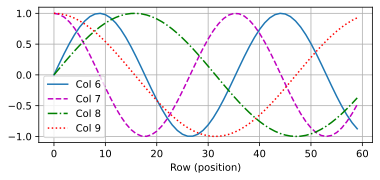

In [7]:
encoding_dim, num_steps = 32, 60
pos_encoding = PositionalEncoding(encoding_dim, 0)
pos_encoding.eval()
X = pos_encoding(torch.zeros((1, num_steps, encoding_dim)))
P = pos_encoding.p[:, :X.shape[1], :]
plot(torch.arange(num_steps), P[0, :, 6:10].T, xlabel='Row (position)',
         figsize=(6, 2.5), legend=["Col %d" % d for d in torch.arange(6, 10)])